Test MSE = 5.6968e-03
Test max abs error = 2.1816e-01

Derivative approximation:
Derivative MSE: 0.6317719479200686
Derivative max abs error: 2.298151405116966


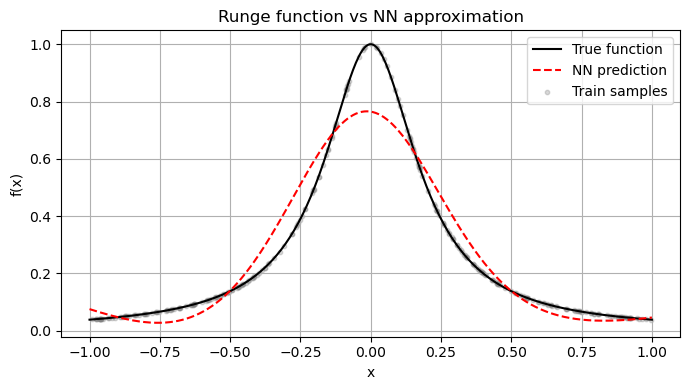

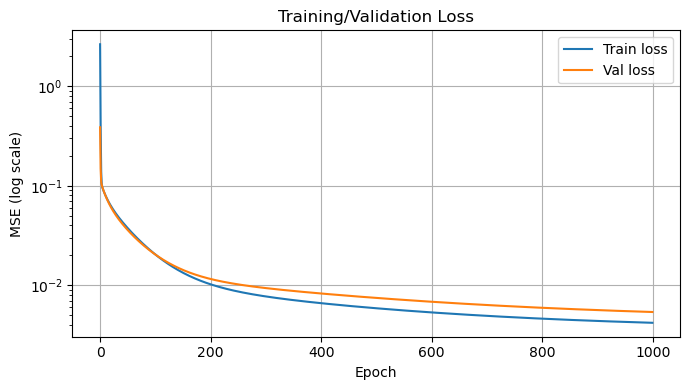

In [6]:
#Use chatgpt to compelete the codes
import numpy as np
import matplotlib.pyplot as plt

#Generate data
def runge(x):
    return 1.0 / (1 + 25 * x**2)

np.random.seed(0)
N = 400
x_all = np.random.uniform(-1, 1, size=(N, 1))
y_all = runge(x_all)

idx = np.arange(N)
np.random.shuffle(idx)
train_idx = idx[:int(0.7*N)]
val_idx   = idx[int(0.7*N):int(0.85*N)]
test_idx  = idx[int(0.85*N):]

x_train, y_train = x_all[train_idx], y_all[train_idx]
x_val, y_val     = x_all[val_idx], y_all[val_idx]
x_test, y_test   = x_all[test_idx], y_all[test_idx]

#Define a small MLP (1 hidden layer)
n_input = 1
n_hidden = 30
n_output = 1

#Xavier init
W1 = np.random.randn(n_input, n_hidden)
b1 = np.zeros((1, n_hidden))
W2 = np.random.randn(n_hidden, n_output)
b2 = np.zeros((1, n_output))

def forward(x):
    z1 = x @ W1 + b1
    a1 = np.tanh(z1)
    z2 = a1 @ W2 + b2
    return z1, a1, z2

def predict(x):
    return forward(x)[-1]

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

#Training loop
lr = 0.03
epochs = 1000
train_loss, val_loss = [], []

for epoch in range(epochs):
    # forward
    z1, a1, y_pred = forward(x_train)
    loss = mse(y_train, y_pred)

    # backward
    dL_dy = 2*(y_pred - y_train)/len(y_train)
    dL_dW2 = a1.T @ dL_dy
    dL_db2 = np.sum(dL_dy, axis=0, keepdims=True)
    dL_da1 = dL_dy @ W2.T
    dL_dz1 = dL_da1 * (1 - np.tanh(z1)**2)
    dL_dW1 = x_train.T @ dL_dz1
    dL_db1 = np.sum(dL_dz1, axis=0, keepdims=True)

    # gradient step
    W2 -= lr * dL_dW2
    b2 -= lr * dL_db2
    W1 -= lr * dL_dW1
    b1 -= lr * dL_db1

    #losses
    train_loss.append(loss)
    val_loss.append(mse(y_val, predict(x_val)))

#Evaluate on test data
y_test_pred = predict(x_test)
test_mse = mse(y_test, y_test_pred)
test_maxerr = np.max(np.abs(y_test - y_test_pred))
print(f"Test MSE = {test_mse:.4e}")
print(f"Test max abs error = {test_maxerr:.4e}")

#Compute derivative of the network vs true derivative
x_grid = np.linspace(-1,1,400).reshape(-1,1)
# true derivative
fprime_true = -50*x_grid/(1+25*x_grid**2)**2

# network derivative analytically
z1 = x_grid @ W1 + b1
a1 = np.tanh(z1)
# derivative of tanh part times weights:
da1_dx = (1 - np.tanh(z1)**2) * W1  # (n_samples,n_hidden)
fprime_pred = da1_dx @ W2  # (n_samples,1)

mse_derivative = np.mean((fprime_pred - fprime_true)**2)
maxabs_derivative = np.max(np.abs(fprime_pred - fprime_true))
print("\nDerivative approximation:")
print("Derivative MSE:", mse_derivative)
print("Derivative max abs error:", maxabs_derivative)

#Plot function and prediction
x_plot = np.linspace(-1,1,400).reshape(-1,1)
y_true_plot = runge(x_plot)
y_pred_plot = predict(x_plot)

plt.figure(figsize=(7,4))
plt.plot(x_plot, y_true_plot, 'k', label='True function')
plt.plot(x_plot, y_pred_plot, 'r--', label='NN prediction')
plt.scatter(x_train, y_train, color='gray', s=10, alpha=0.3, label='Train samples')
plt.legend()
plt.title('Runge function vs NN approximation')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
plt.tight_layout()

#Plot loss curves
plt.figure(figsize=(7,4))
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Val loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('MSE (log scale)')
plt.title('Training/Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()